In [1]:
from fastscnn.data.tfds_to_torch import TFDataIterableDataset
import torch
import tensorflow_datasets as tfds
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

from refinenet.models.uncertainty_utils import UncertaintyFitter
from refinenet.models.refinenet_with_uncertainty import get_uncertainty_net

import numpy as np
import torch
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import cv2


In [2]:
def softmax(X, theta=1.0, axis=None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1:
        p = p.flatten()

    return p


In [3]:
# Data Transforms
class TfToEmbodiedLearning:
     def __call__(self, data):
        sample = {}
        sample['image'] = data[0]
        sample['mask'] = data[1]
        return sample

class Normalize:
    def __init__(self, mean, std, cpu_mode = False):
        self.mean = mean
        self.std = std
        if torch.cuda.is_available() and not cpu_mode:
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = (image - self.mean) / (self.std)
        return {'image': image, 'mask': mask}

class AsFloat:
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = image.float()
        return {'image': image, 'mask': mask}

In [4]:
IMG_MEAN = torch.tensor(np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1)))
IMG_STD = torch.tensor(np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1)))

tf_transform = transforms.Compose(
  [TfToEmbodiedLearning(),Normalize(IMG_MEAN, IMG_STD, cpu_mode = True), AsFloat()])

embodied_transform = transforms.Compose(
  [Normalize(IMG_MEAN, IMG_STD, cpu_mode = False), AsFloat()])

In [5]:
n_components = 20
covariance_type = 'tied'
batchsize = 4
reg_covar = 1e-6
network_size = 50
output_checkpoint = "./checkpoint_uncertainty_refinenet_size_{}.pth".format(network_size)

model = get_uncertainty_net(size=network_size, num_classes=40, n_feature_for_uncertainty=64, n_components=n_components,
                            covariance_type=covariance_type, reg_covar=reg_covar)
if torch.cuda.is_available():
  model = model.cuda()

data = tfds.load('Nyu_depth_v2_labeled',
                 split='full',
                 as_supervised=True)
valdata = data.take(200)
traindata = data.skip(200)


def data_converter(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.cast(label, tf.int64)
  # move channel from last to 2nd
  image = tf.transpose(image, perm=[2, 0, 1])
  return image, label


traindata = TFDataIterableDataset(
  traindata.cache().prefetch(10000).map(data_converter))
valdata = TFDataIterableDataset(valdata.map(data_converter))
train_loader = torch.utils.data.DataLoader(dataset=traindata,
                                           batch_size=batchsize,
                                           pin_memory=True,
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=valdata,
                                         batch_size=batchsize,
                                         pin_memory=True,
                                         drop_last=True)

with UncertaintyFitter(model, total_features=100000, features_per_batch=500) as fitter:
  for i, data in enumerate(train_loader):
    # normalize and to float
    images = tf_transform(data)['image']
    print("Obtaining features for batch {}/{}".format(i, len(train_loader)), end='\r')
    fitter(images.cuda())

torch.save(model.state_dict(), output_checkpoint)

fitting PCA Module. Reducing feature dimension from 256 to 64
Fitting GMM Model, Params: num_components:20, covariance_type: tied, reg_covar: 1e-06


In [6]:
# Some uncertainties on training set (NYU)

In [7]:

plt.rcParams['figure.figsize'] = [5, 10]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

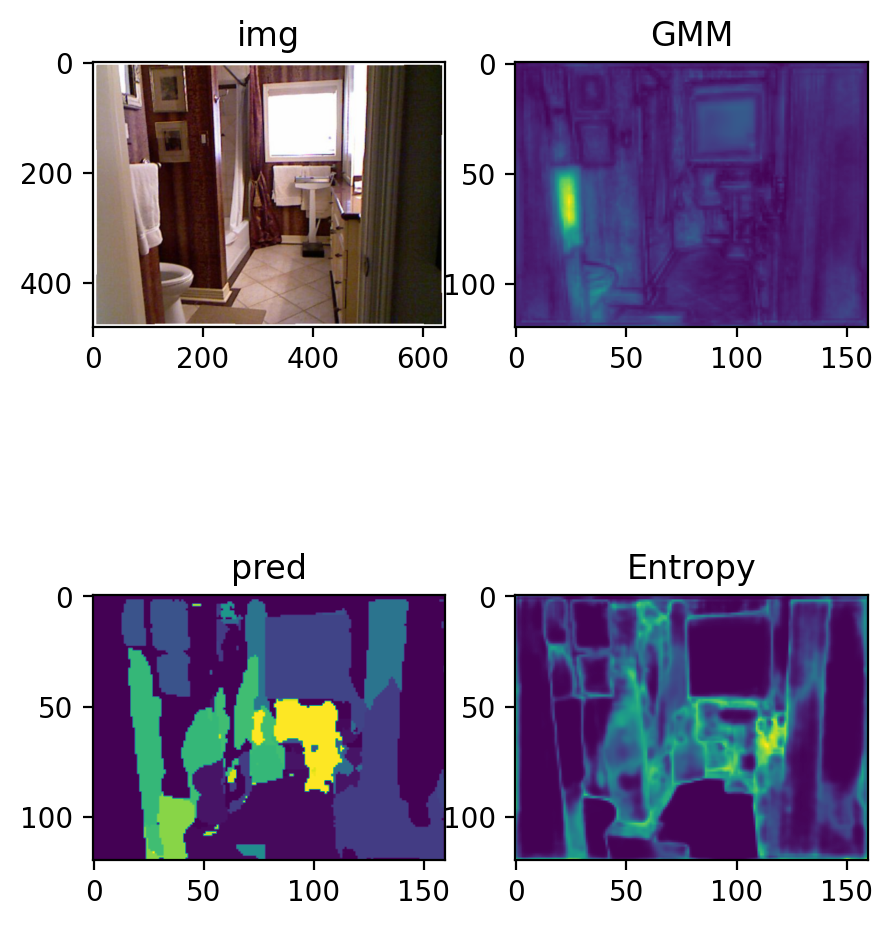

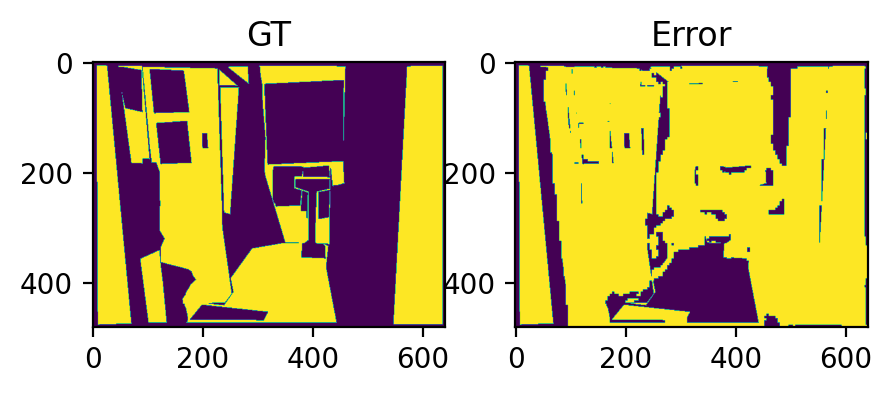

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


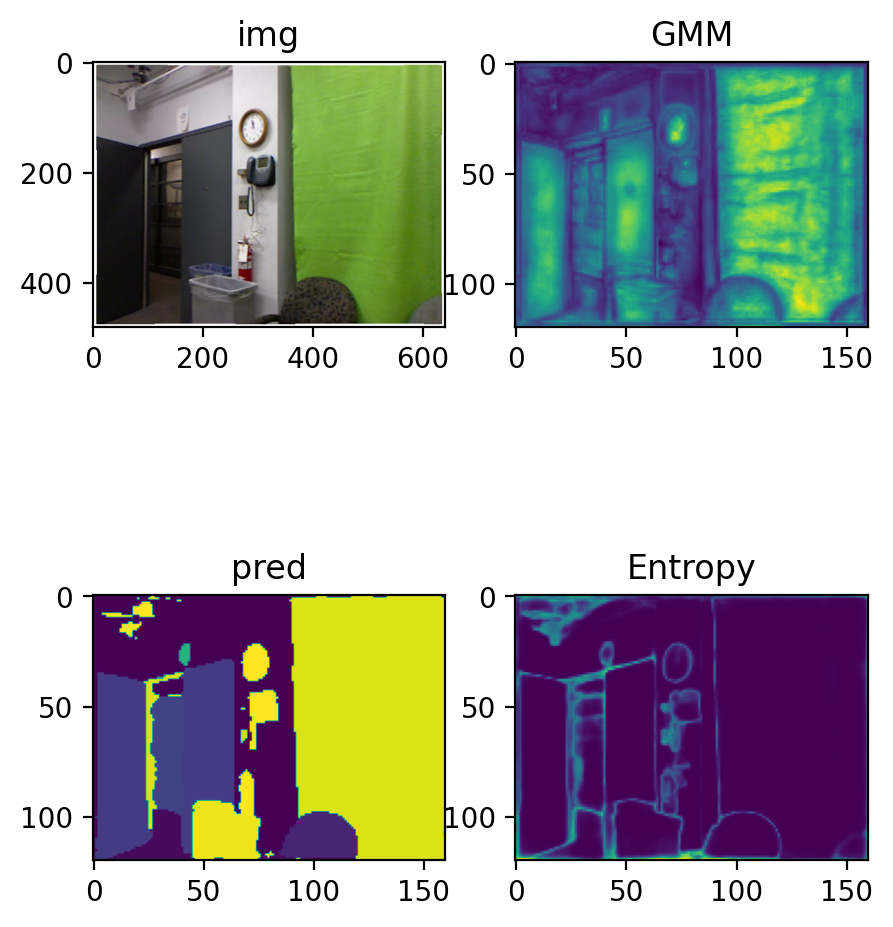

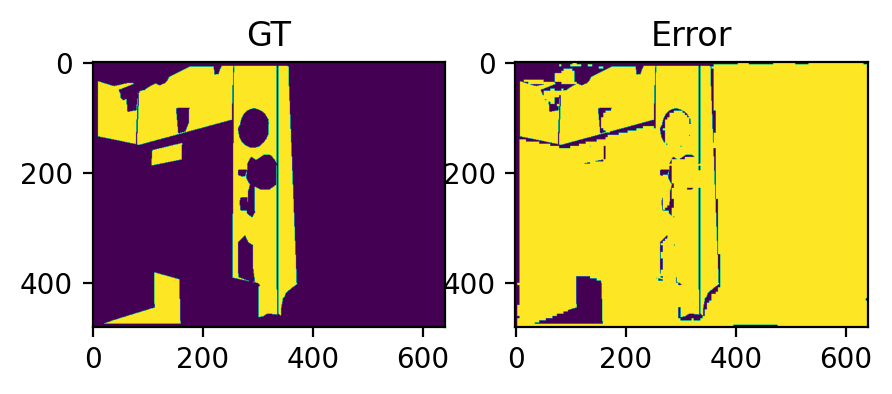

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


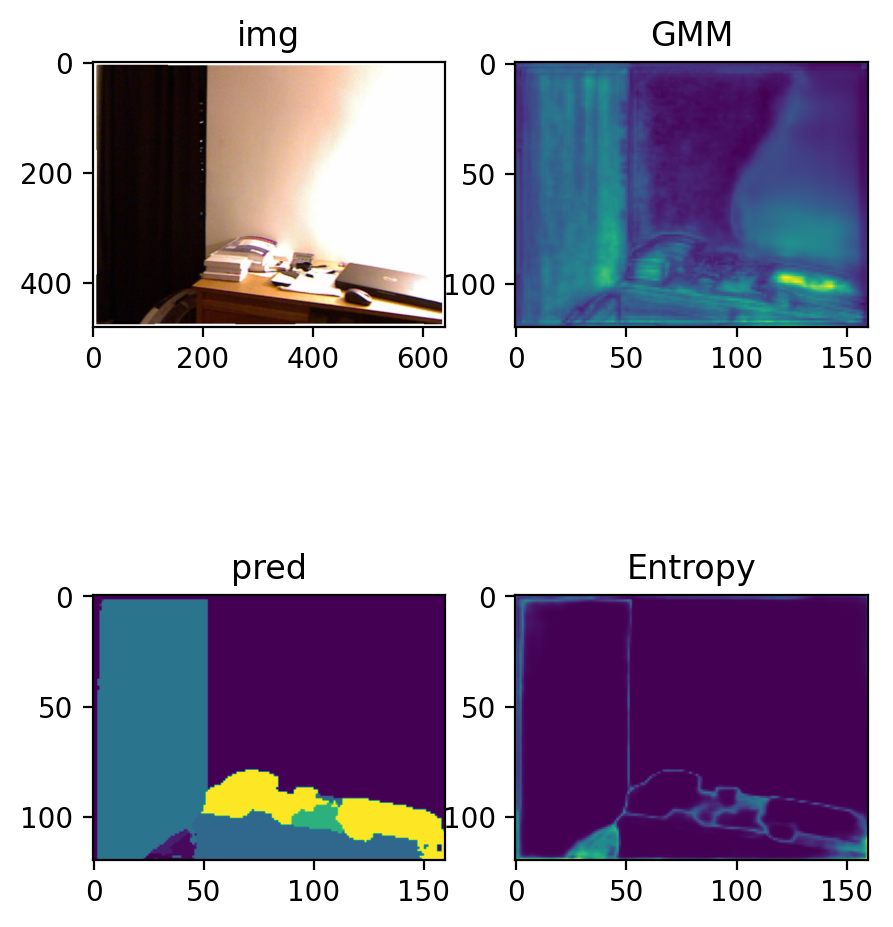

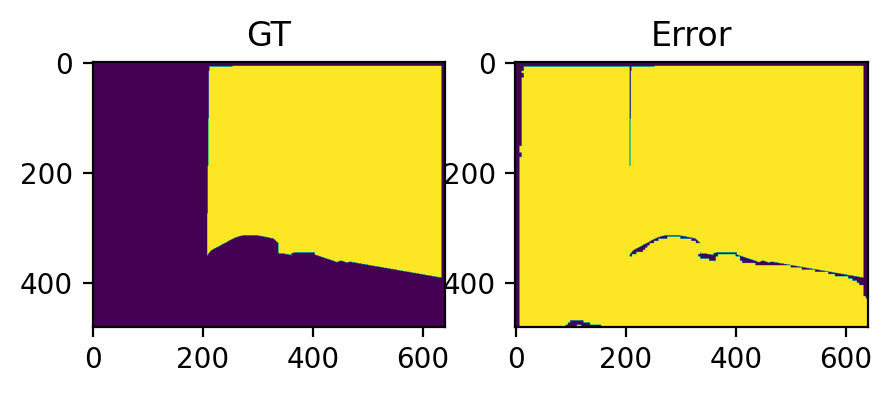

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


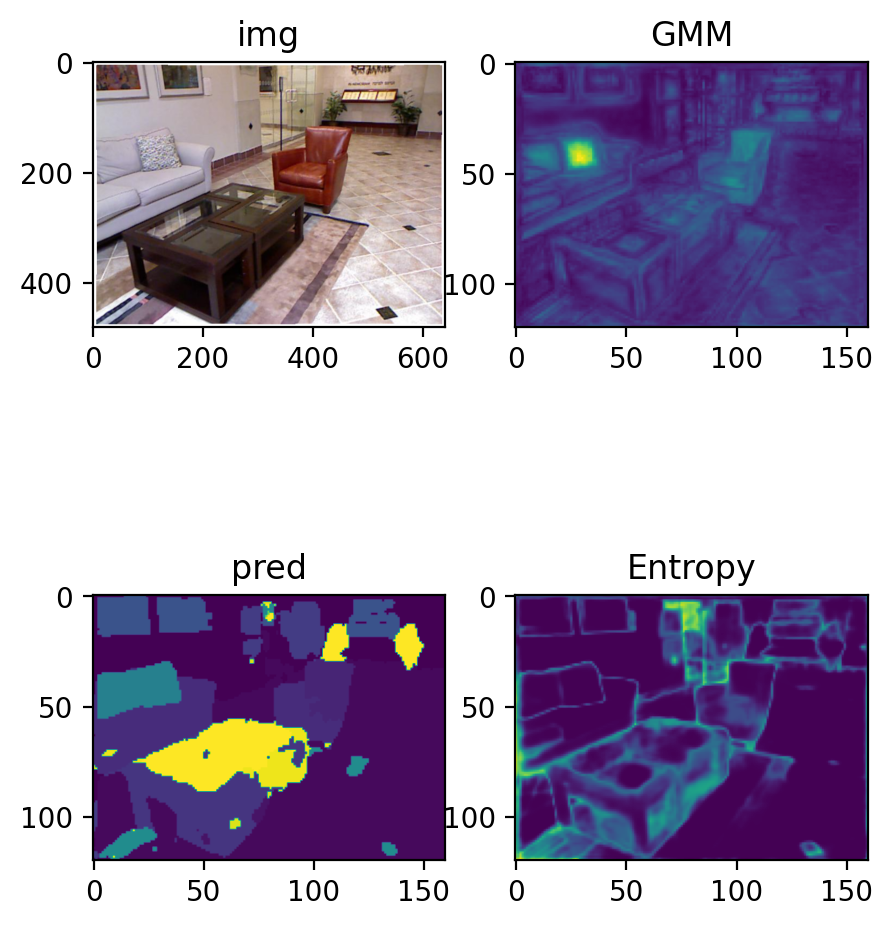

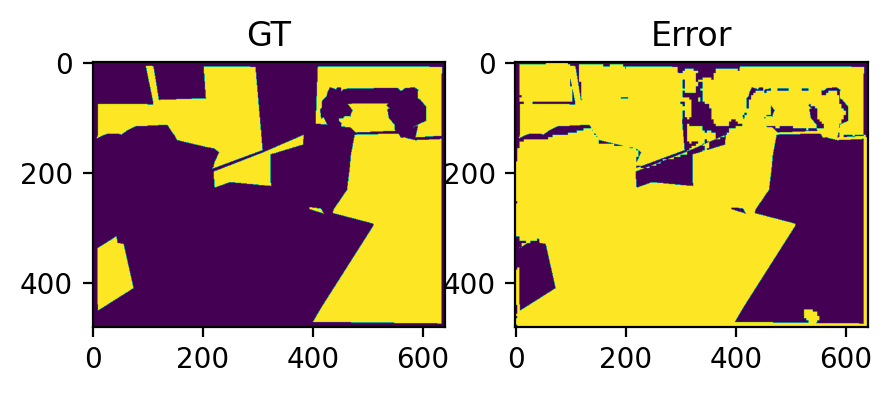

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


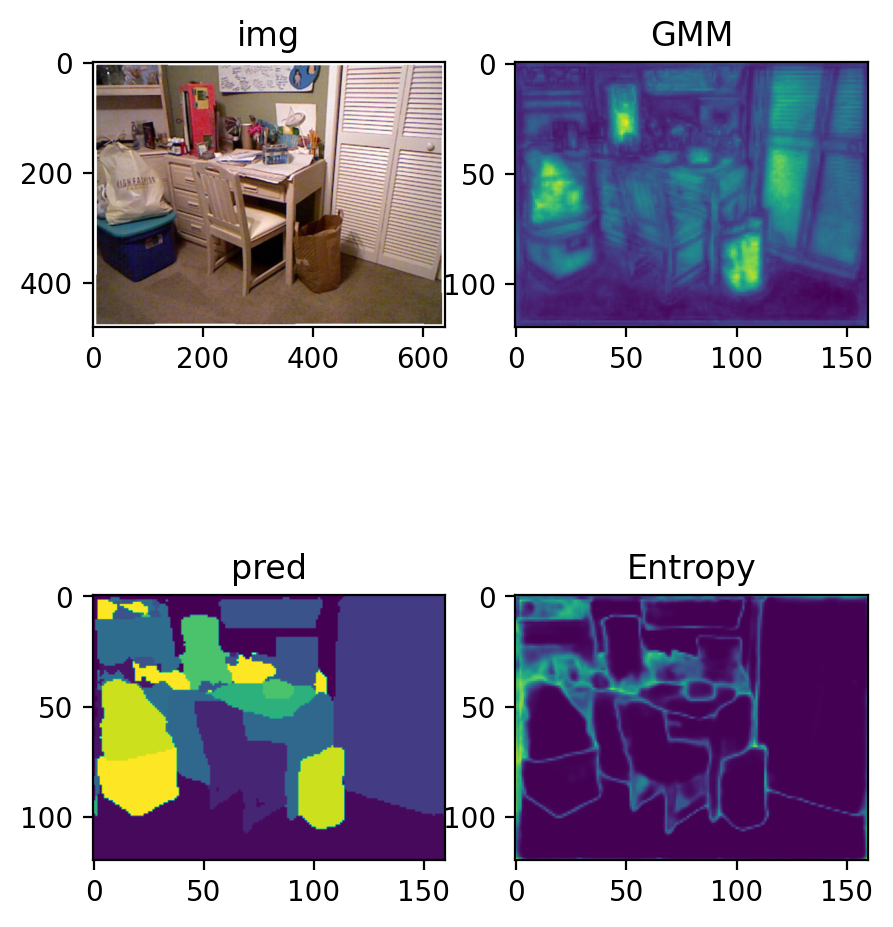

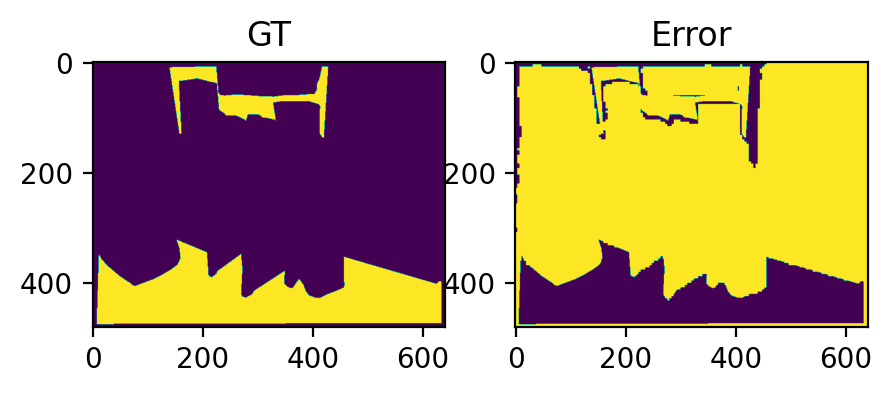

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


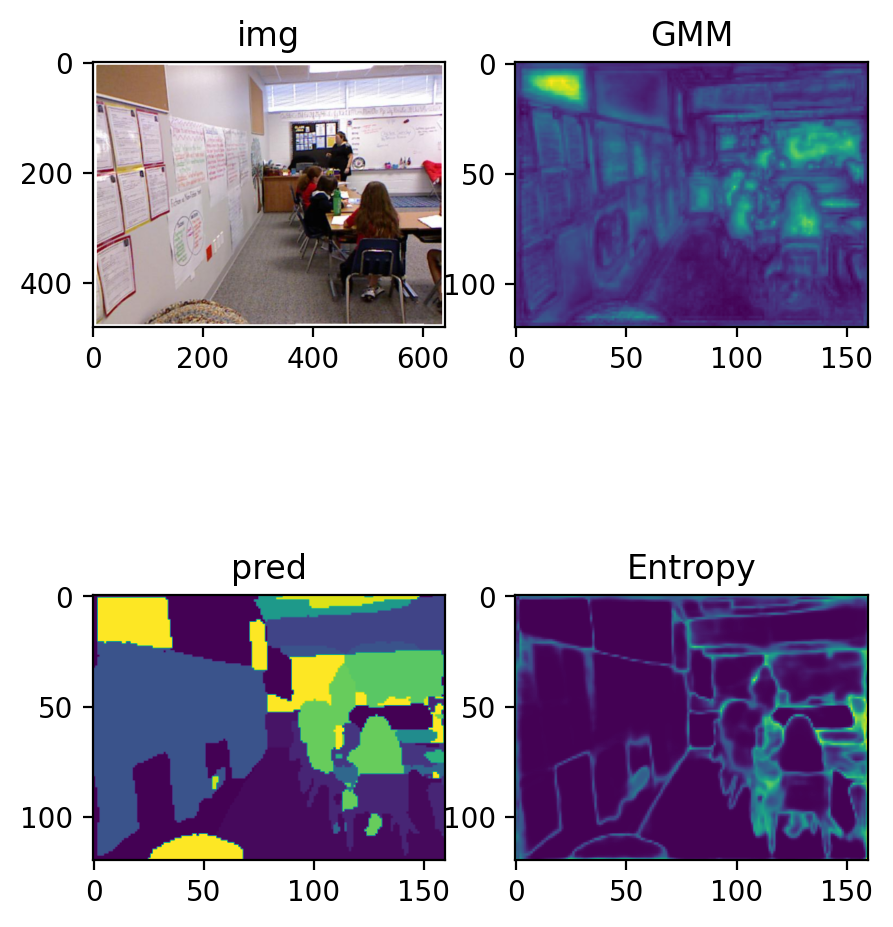

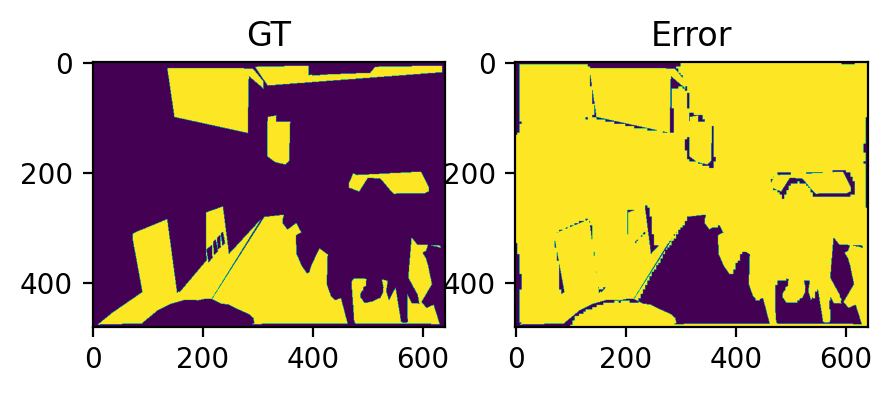

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


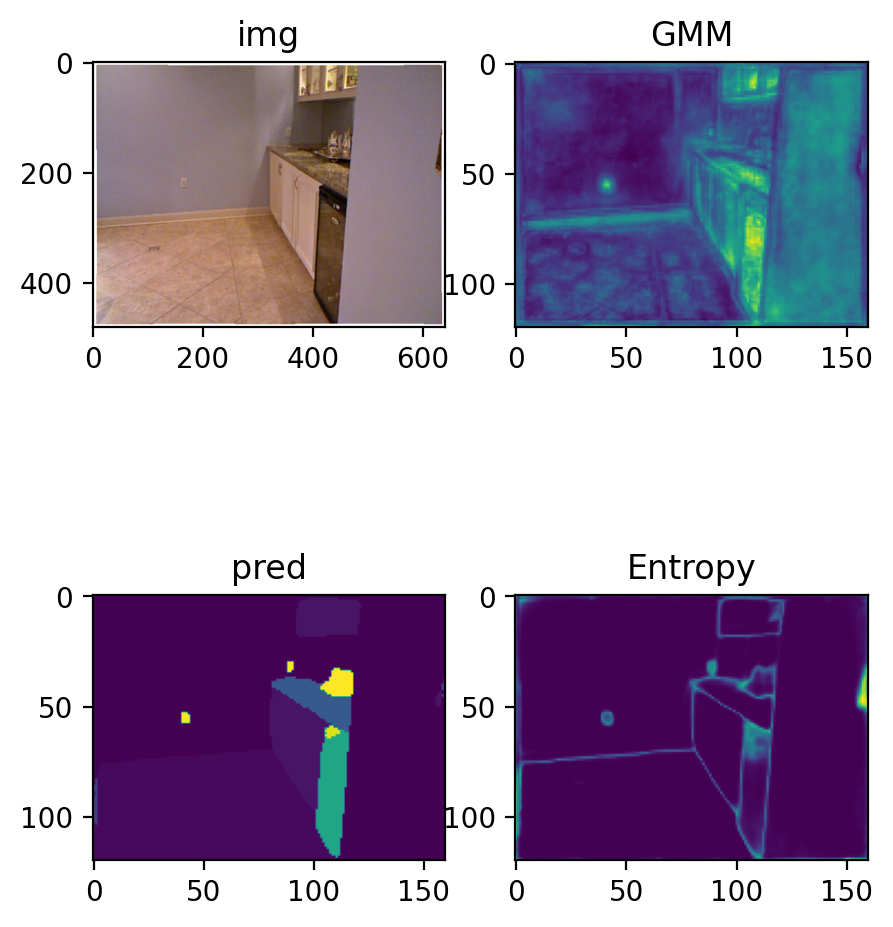

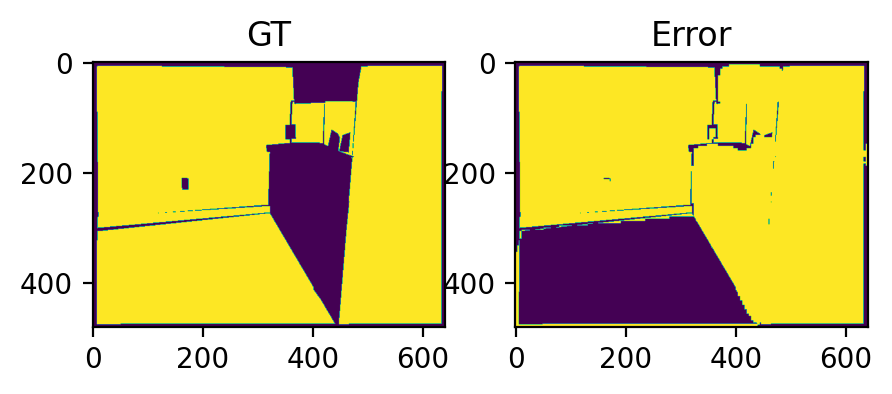

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
model.eval()
cnt = 20
for idx, images in enumerate(torch.utils.data.DataLoader(dataset=traindata,
                                           batch_size=1,
                                           pin_memory=True,
                                           drop_last=True)):
    i = tf_transform(images)
    if  idx >= 6 and idx < cnt and idx % 2 == 0:
        plt.subplot(3,2,1)
        plt.imshow(images[0].numpy().squeeze().transpose(1,2,0))
        plt.title("img")
        plt.subplot(3,2,3)
        p = model(i['image'].cuda())
        pred= p[0].cpu().detach().numpy()
        plt.imshow(np.argmax(pred, axis = 1).transpose(1, 2, 0))
        plt.title("pred")
        
        plt.subplot(3,2,2)
        plt.imshow(p[1].cpu().detach().numpy().squeeze().transpose(0, 1))
        plt.title("GMM")

        plt.subplot(3,2,4)
        pred_rs = pred.squeeze().transpose(1,2,0)
        sm = softmax(pred_rs, axis = -1)
        plt.imshow(-np.sum((sm*np.log(sm)), axis = -1))
        plt.title("Entropy")
        plt.show()
        
        plt.subplot(3,2,5)
        
        mask_np =  i['mask'].cpu().detach().numpy().squeeze()
        plt.imshow(mask_np)
        plt.title("GT")
        plt.subplot(3,2,6)
        
        pred_np = np.argmax(pred, axis = 1).transpose(1,2,0)
        pred_res = cv2.resize(pred_np.astype(np.uint8),dsize=(mask_np.shape[1],mask_np.shape[0]), interpolation=cv2.INTER_NEAREST)
        plt.imshow(pred_res != mask_np)
        plt.title("Error")
        plt.show()
                   
        print("-"*200)

In [9]:
from embodied_active_learning.utils import pytorch_utils

Creating dataloader with params: /home/rene/thesis/test_small_flat,120,None,None,False
[DATALOADER] going to limit images to 120


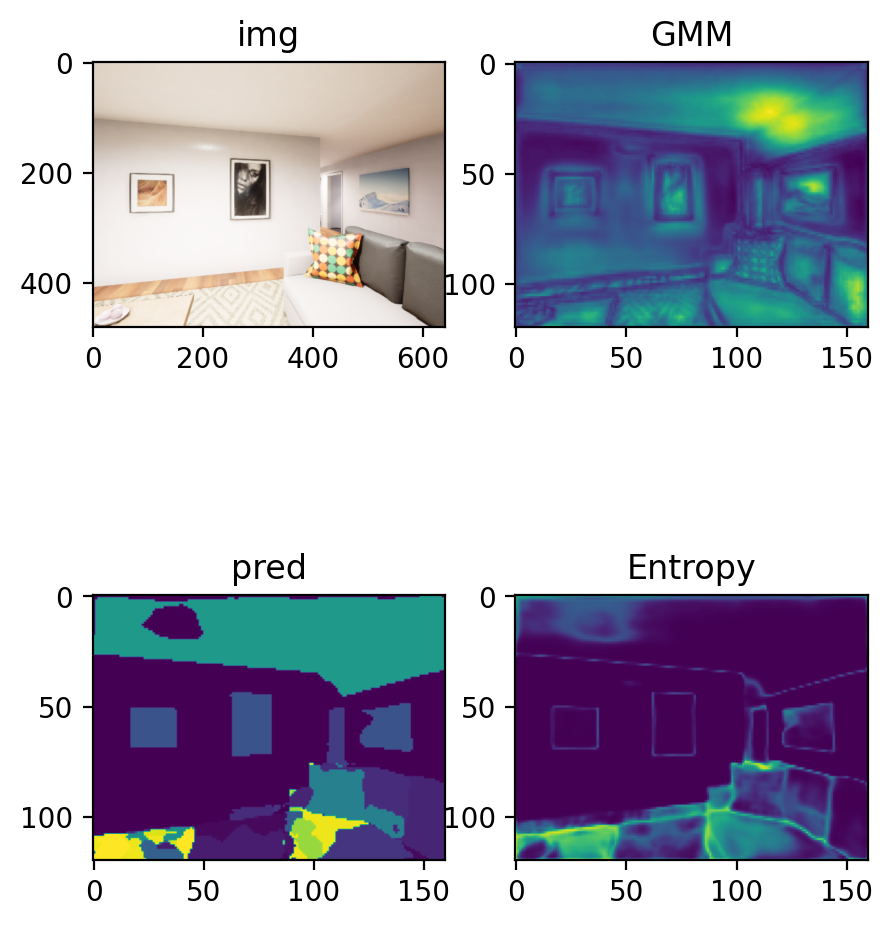

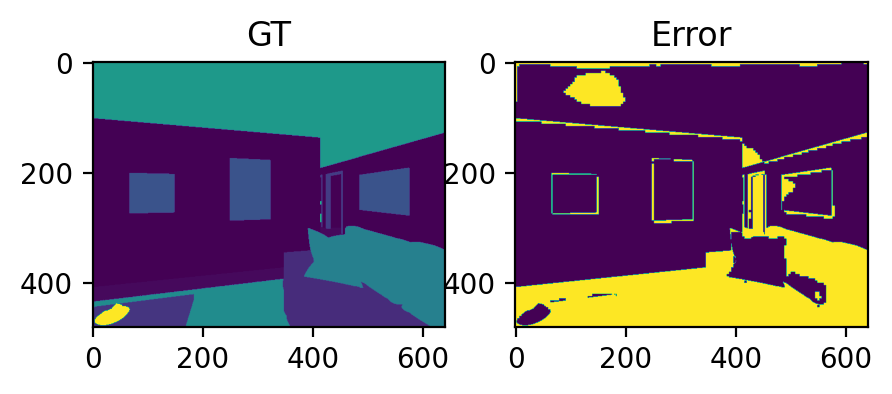

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


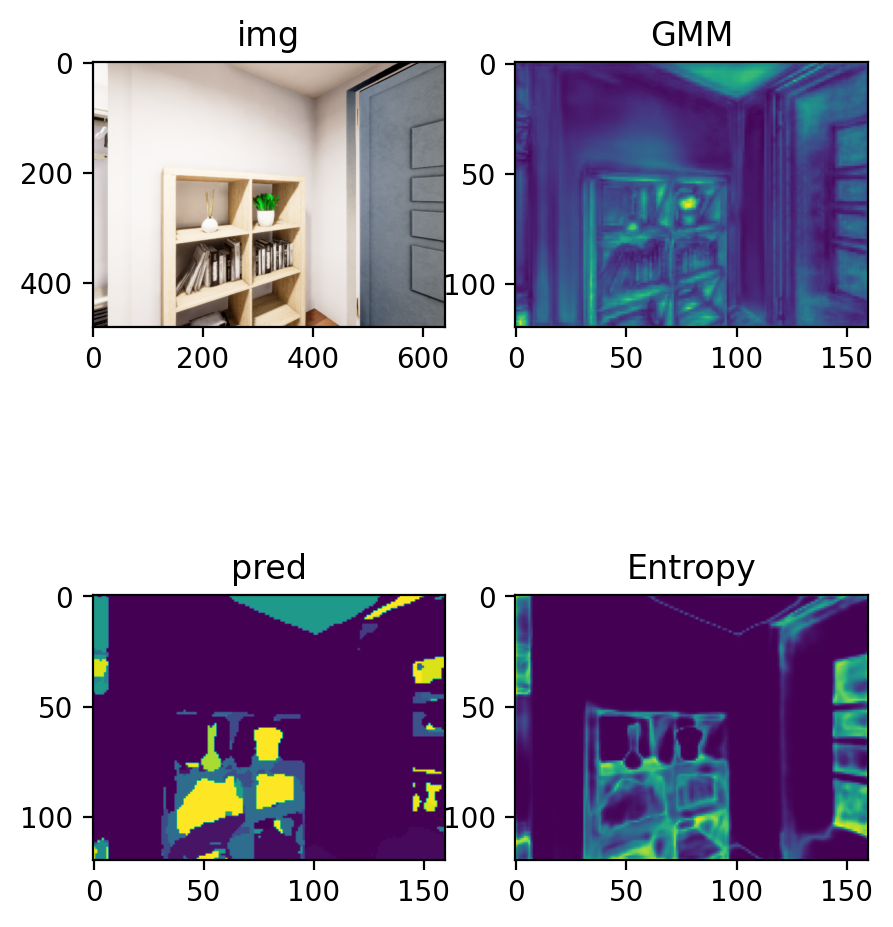

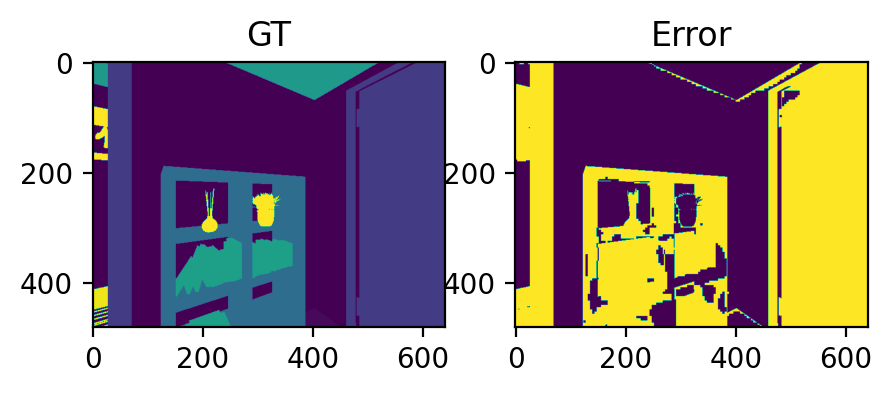

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


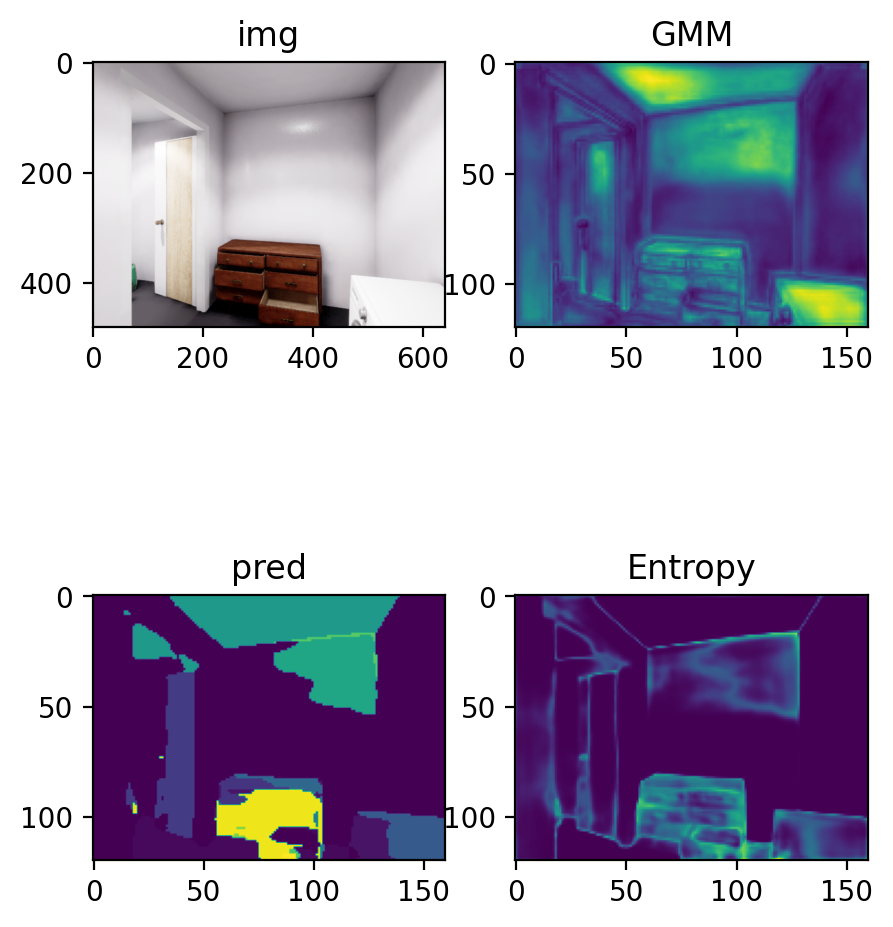

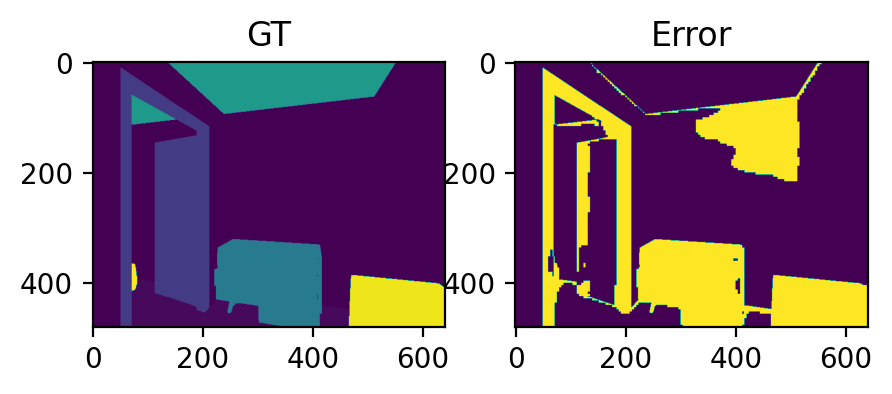

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


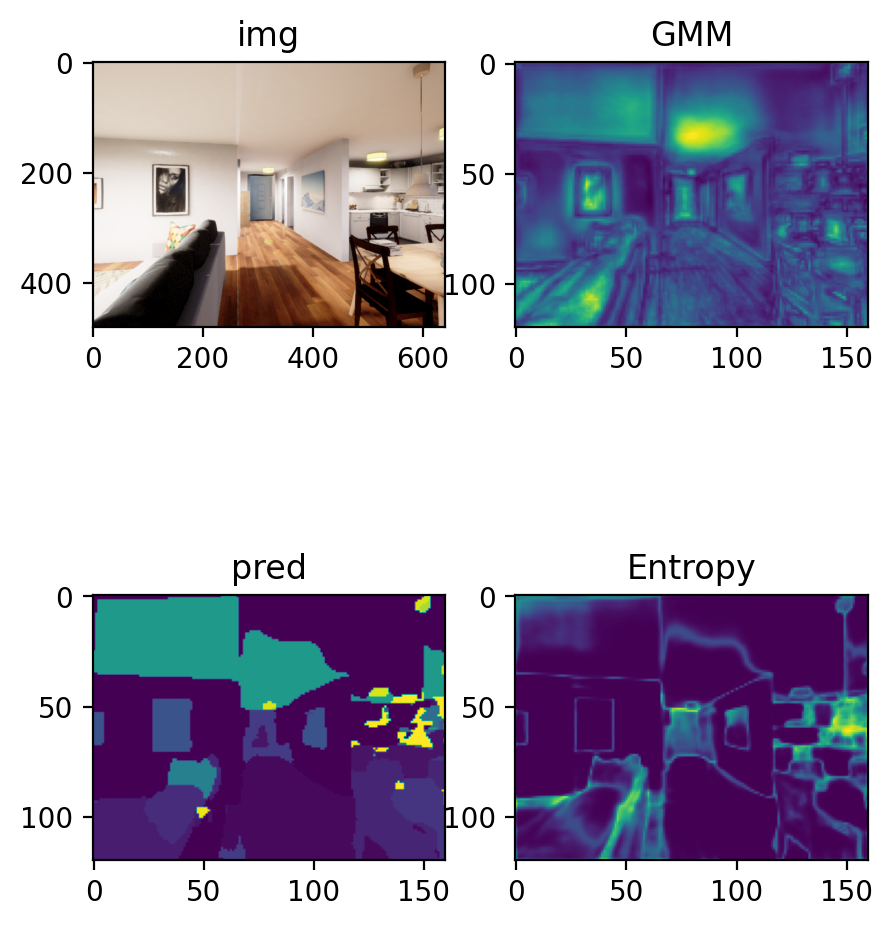

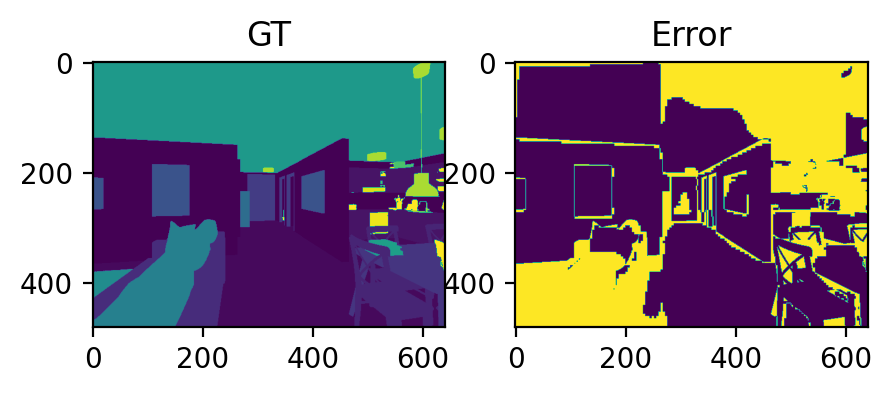

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


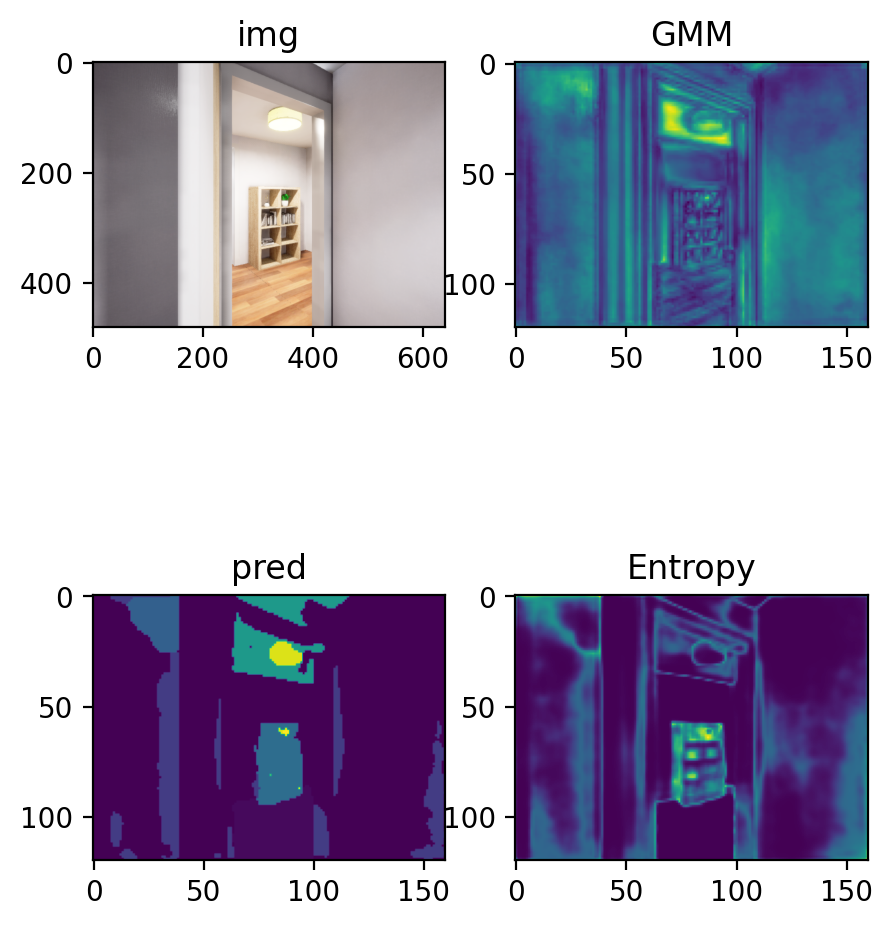

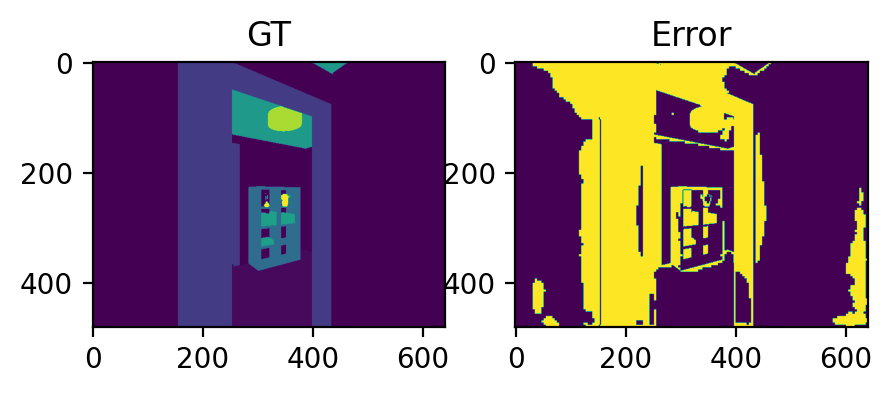

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


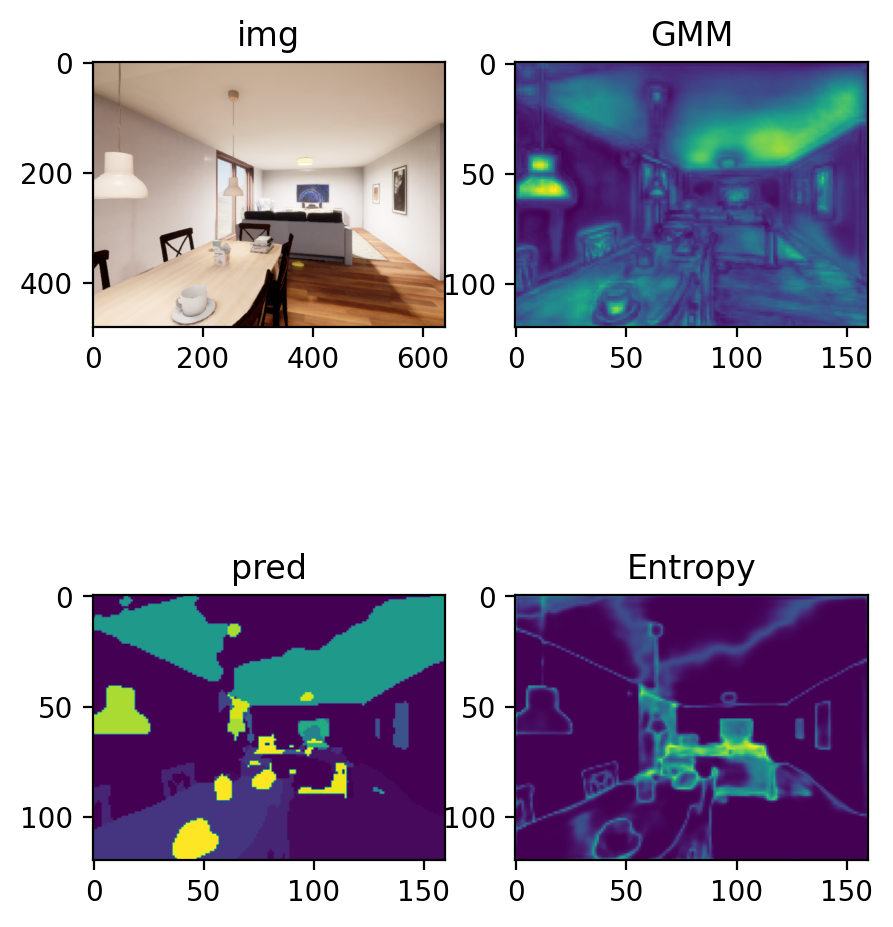

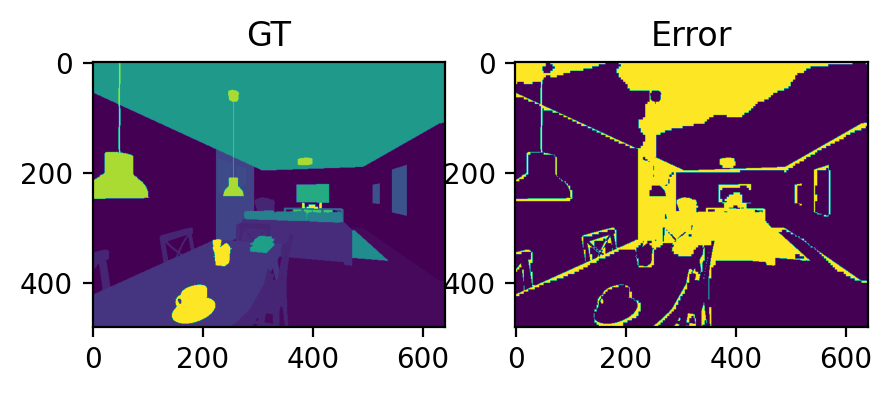

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


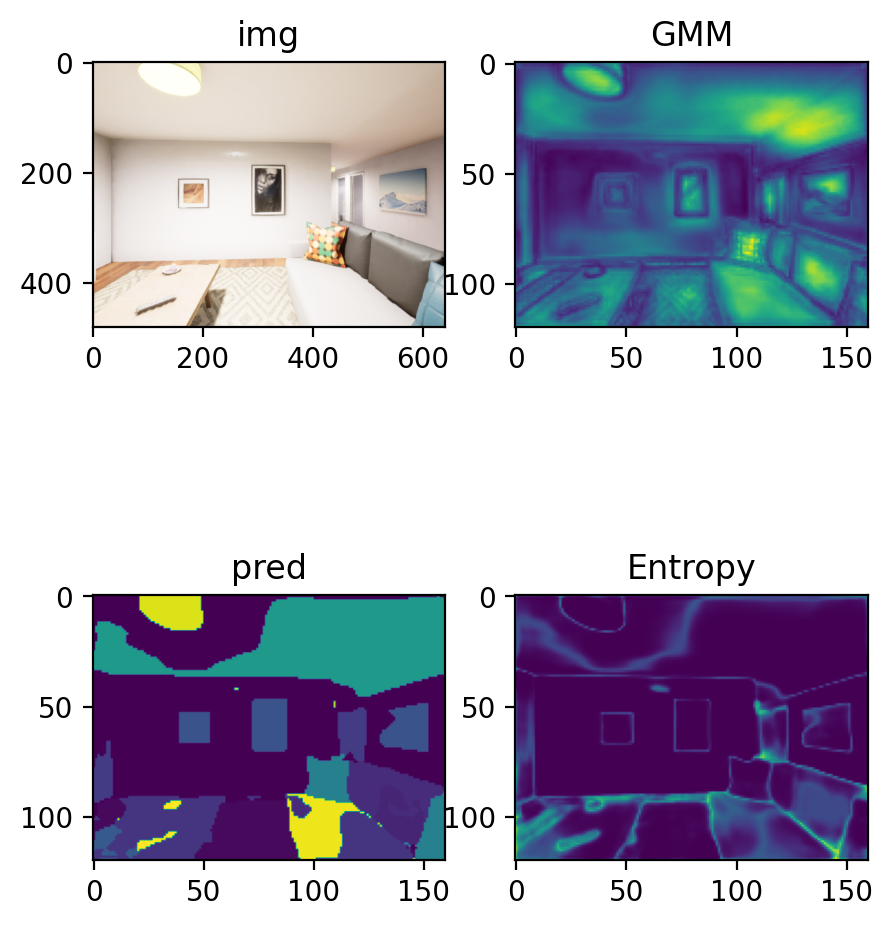

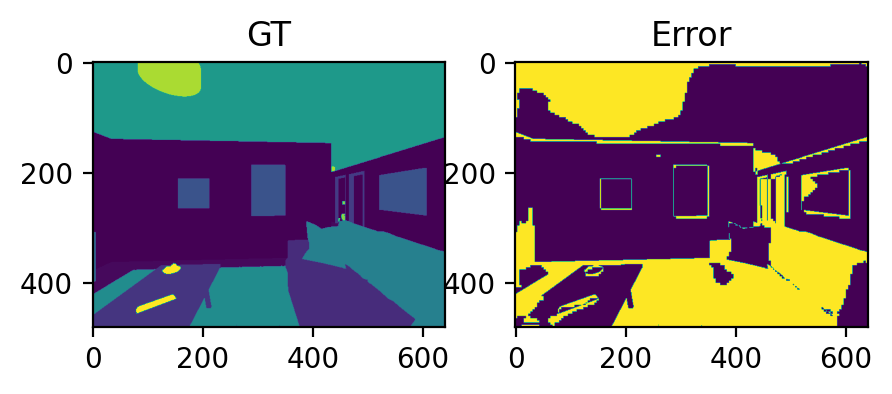

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
model.eval()
cnt = 20
for idx, images in enumerate(torch.utils.data.DataLoader(pytorch_utils.DataLoader.DataLoaderSegmentation("/home/rene/thesis/test_small_flat", transform=None, num_imgs=120),
                             batch_size=1)):
    i = embodied_transform(images)
    if  idx >= 6 and idx < cnt and idx % 2 == 0:
        plt.subplot(3,2,1)
        plt.imshow(images['image'].squeeze().cpu().detach().numpy().transpose(1, 2, 0))
        plt.title("img")
        plt.subplot(3,2,3)
        p = model(i['image'].cuda())
        pred= p[0].cpu().detach().numpy()
        plt.imshow(np.argmax(pred, axis = 1).transpose(1, 2, 0))
        plt.title("pred")
        
        plt.subplot(3,2,2)
        plt.imshow(p[1].cpu().detach().numpy().squeeze().transpose(0, 1))
        plt.title("GMM")

        plt.subplot(3,2,4)
        pred_rs = pred.squeeze().transpose(1,2,0)
        sm = softmax(pred_rs, axis = -1)
        plt.imshow(-np.sum((sm*np.log(sm)), axis = -1))
        plt.title("Entropy")
        plt.show()
        
        plt.subplot(3,2,5)
        
        mask_np =  i['mask'].cpu().detach().numpy().squeeze()
        plt.imshow(mask_np)
        plt.title("GT")
        plt.subplot(3,2,6)
        
        pred_np = np.argmax(pred, axis = 1).transpose(1,2,0)
        pred_res = cv2.resize(pred_np.astype(np.uint8),dsize=(mask_np.shape[1],mask_np.shape[0]), interpolation=cv2.INTER_NEAREST)
        plt.imshow(pred_res != mask_np)
        plt.title("Error")
        plt.show()
                   
        print("-"*200)